I'm giving a talk about my 2DHOD AB models and their use in inferring cosmology. I need to make a few plots for that, and I'd like to do it all in one place. 

I need to make:
 * Cen-sat HOD plot x
 * Split decorated HOD plot x
 * Decorated HOD step func plot
 * “” for Yao model, cont model
 * SHAM ratio(s) plot
 * Tabulated HOD plot


In [1]:
import numpy as np
from pearce.mocks.kittens import TrainingBox, Chinchilla
from scipy.stats import binned_statistic, binned_statistic_2d

In [2]:
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, get_haloprop_of_galaxies

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()
sns.set_palette('deep')

In [4]:
plt.rcParams.update({'font.size': 18})
np.random.seed(0)

In [5]:
cat = TrainingBox(boxno=0, system='ki-ls')
cat.load(1.0, HOD='zheng07')

In [6]:
cat.model.param_dict['logMmin'] = 13.0
cat.model.param_dict['logM0'] = 12.5

In [7]:
print cat.model.param_dict

{'logM0': 12.5, 'sigma_logM': 0.26, 'logMmin': 13.0, 'alpha': 1.06, 'logM1': 13.31}


In [8]:
cat.populate(min_ptcl=50)

In [9]:
mass_bin_range = (11,16)
mass_bin_size = 0.1
cen_hod = cat.calc_hod(mass_bin_range=mass_bin_range, mass_bin_size=mass_bin_size, component='central')
sat_hod = cat.calc_hod(mass_bin_range=mass_bin_range, mass_bin_size=mass_bin_size, component='satellite')

In [10]:
mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1],
                           int((mass_bin_range[1] - mass_bin_range[0]) / mass_bin_size) + 1)
mass_bin_centers = (mass_bins[:-1] + mass_bins[1:]) / 2

## TODO check little h 

---

In [11]:
# TODO consistent plot language between each of these. Each model should have a corresponding color

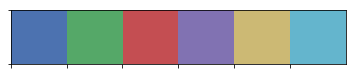

In [12]:
current_palette = sns.color_palette()
sns.palplot(current_palette)


In [13]:
model_color_map = {'HOD': (current_palette[0], "GnBu_d"),
                    'HSAB': (current_palette[1], "YlGn_d"),
                   'SHAM': (current_palette[2], "OrRd_d"),
                   'CAB': (current_palette[3], "RdPu_d"),
                   'CorrAB': (current_palette[4], "YlOrBr_d"),
                    'Halos': (current_palette[5], 'PuBu_d')} # add CMAPs too

In [14]:
cat.halocat.halo_table.colnames

['halo_upid',
 'halo_vx',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_rvir',
 'halo_mvir',
 'halo_id',
 'halo_nfw_conc',
 'halo_hostid',
 'halo_local_density_1',
 'halo_local_density_5',
 'halo_local_density_10',
 'halo_mvir_host_halo']

In [15]:
#sec_haloprop_key = 'halo_nfw_conc' 
sec_haloprop_key ='halo_local_density_10'

In [16]:
def split_hod_plot(HOD, ab_params, n_splits = 4, cmap_name = 'blue', ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    cat.load_model(1.0, HOD=HOD, hod_kwargs= {'sec_haloprop_key': sec_haloprop_key})
    cat.model.param_dict['logMmin'] = 13.0
    cat.model.param_dict['logM0'] = 12.5
    
    cat.populate(ab_params, min_ptcl = 100)
    print cat.model.param_dict
    catalog = cat.model.mock.galaxy_table
    sec_percentiles = compute_conditional_percentiles(prim_haloprop = cat.model.mock.halo_table['halo_mvir'],\
                                                  sec_haloprop = cat.model.mock.halo_table[sec_haloprop_key],
                                              prim_haloprop_bin_boundaries= mass_bins)
    
    sec_gal_percentiles = get_haloprop_of_galaxies(catalog['halo_id'], cat.model.mock.halo_table['halo_id'],
                                               sec_percentiles)
    
    # TODO bins here
    hods = np.zeros((n_splits, len(mass_bin_centers)))
    perc_ranges = np.linspace(0,1, n_splits+1)
    
    cmap = sns.color_palette(cmap_name, n_splits)
    #cmap = sns.dark_palette(cmap_name, n_splits)

    for i,c in enumerate(cmap):
        sec_bin_gals = np.logical_and(perc_ranges[i] < sec_gal_percentiles, sec_gal_percentiles<perc_ranges[i+1])
        sec_bin_halos = np.logical_and(perc_ranges[i] < sec_percentiles, sec_percentiles<perc_ranges[i+1])

        sec_gal_hist, _ = np.histogram(catalog[sec_bin_gals]['halo_mvir'], bins = mass_bins)
        sec_halo_hist, _= np.histogram(cat.model.mock.halo_table[sec_bin_halos]['halo_mvir'], bins = mass_bins)
        
        hods[i, :] = sec_gal_hist*1.0/sec_halo_hist
        ax.plot(mass_bin_centers, hods[i], c = c, label = '%0.2f < p < %0.2f'%tuple(perc_ranges[i:i+2]))

    
    gal_hist, _ = np.histogram(catalog['halo_mvir'], bins = mass_bins)
    halo_hist, _= np.histogram(cat.model.mock.halo_table['halo_mvir'], bins = mass_bins)
    full_hod = gal_hist*1.0/halo_hist
    
    
    ax.plot(mass_bin_centers, full_hod, label = 'Full HOD', color = 'k')
    ax.legend(loc='best', frameon=False)
    ax.loglog()
    ax.set_xlim(1e12,5e14)
    ax.set_ylim([0, 40])
    #plt.xlabel(r"Host Halo Mass [$M_{\odot}$]")
    ax.set_ylabel(r"$\langle N_t | M \rangle$")
    #plt.show()

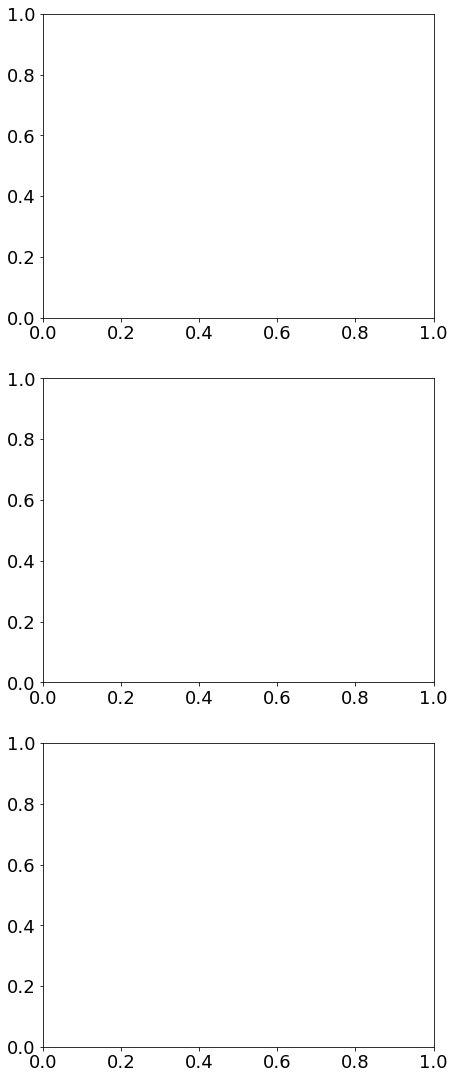

In [17]:
%config InlineBackend.close_figures=False # keep figures open in pyplot
for fnum in plt.get_fignums():
    plt.close(fnum)
fig, axes = plt.subplots(3,1, figsize = (7,19))

---

In [18]:
def select_mass_bin(bin_no, arr, mass_arr, mass_bins=mass_bins):
    in_bin = np.logical_and(mass_bins[bin_no] < mass_arr, mass_arr < mass_bins[bin_no+1])
    return arr[in_bin]

In [19]:
def single_bin_cen_occ_plot(HOD, ab_params, bin_no, label,  color = current_palette[1], ax = None, plot_HOD=False):
    if ax is None:
        fig, ax = plt.subplot(1,1)
        
    cat.load_model(1.0, HOD=HOD, hod_kwargs= {'sec_haloprop_key': sec_haloprop_key})
    cat.model.param_dict['logMmin'] = 13.0
    cat.model.param_dict['logM0'] = 12.5

    cat.populate(ab_params, min_ptcl = 100)
    
    mean_occ = cat.model._input_model_dictionary['centrals_occupation'].mean_occupation
    
    base_mean_occ = cat.model._input_model_dictionary['centrals_occupation'].baseline_mean_occupation
    baseline_result = base_mean_occ(prim_haloprop = cat.model.mock.halo_table['halo_mvir'])
    
    pert_result = mean_occ(prim_haloprop = cat.model.mock.halo_table['halo_mvir'],\
                           sec_haloprop = cat.model.mock.halo_table[sec_haloprop_key])
    
    pert_in_bin = select_mass_bin(bin_no, pert_result, cat.model.mock.halo_table['halo_mvir'])
    baseline_in_bin = select_mass_bin(bin_no, baseline_result, cat.model.mock.halo_table['halo_mvir'])
    sec_in_bin = select_mass_bin(bin_no, cat.model.mock.halo_table[sec_haloprop_key], cat.model.mock.halo_table['halo_mvir'])
    
    sec_sort_idx = np.argsort(sec_in_bin)
    baseline_in_bin_avg = binned_statistic(np.linspace(0, 1, len(sec_sort_idx)),
                                       baseline_in_bin[sec_sort_idx], bins = 100)[0]
    pert_in_bin_avg = binned_statistic(np.linspace(0, 1, len(sec_sort_idx)),
                                       pert_in_bin[sec_sort_idx], bins = 100)[0]

    # TODO compute mean in bins of conc perc
    if plot_HOD:
        ax.plot(np.linspace(0,1,100), baseline_in_bin_avg, c = model_color_map['HOD'][0], label = 'HOD', lw = 2)
    
    ax.plot(np.linspace(0,1,100), pert_in_bin_avg, c=color, label = label, lw = 2)
    
    ax.set_ylim([-0.2,1.2])

    #plt.title(r'$\log_{10}M = $ %0.1f'%np.log10(mass_bin_centers[bin_no]))
    #plt.xlabel('Secondary Halo Propety Percentile')
    #plt.ylabel(r'$\langle N_{cen} | M \rangle$')
    #plt.show()

In [20]:
bin_no = 19

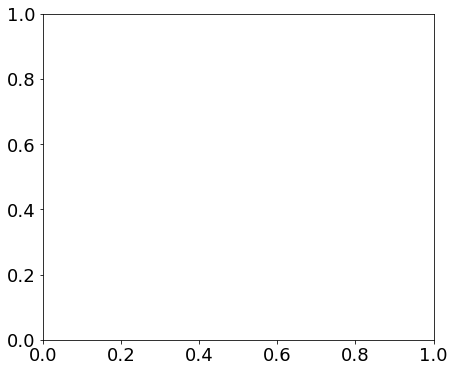

In [21]:
for fnum in plt.get_fignums():
    plt.close(fnum)
fig, ax = plt.subplots(1,1, figsize = (7,6))

---

In [22]:
from AbundanceMatching import *
from halotools.mock_observables import tpcf, tpcf_one_two_halo_decomp
from halotools.sim_manager import RockstarHlistReader

In [23]:
#sham clusterings computed on ds14b
rbins = np.logspace(-1.1, 1.6, 19)
rbc = (rbins[1:]+rbins[:-1])/2.0

### TODO Change these to use other catalogs, UM

In [24]:
cat2 = Chinchilla(400, 2048, system='ki-ls')

cat2.load_catalog(1.0)
halocat = cat2.halocat.halo_table

In [25]:
def make_sham(halocat, ab_property, nd=5e-4):
    #smf = np.genfromtxt('smf_dr72bright34_m7_lowm.dat', skip_header=True)[:,0:2]
    #af = AbundanceFunction(smf[:,0], smf[:,1], (9.0, 12.9), faint_end_first = True)
    lf = np.genfromtxt('/u/ki/swmclau2/des/AB_tests/lf_r_sersic_r.dat', skip_header=True)
    #smf = np.genfromtxt('/home/users/swmclau2/Git/pearce/bin/shams/smf_dr72bright34_m7_lowm.dat', skip_header=True)[:,0:2]

    af = AbundanceFunction(lf[:,1], lf[:,2],(-26, -12), )
    #af = AbundanceFunction(smf[:,0], smf[:,1], (9.0, 12.9), faint_end_first = True)

    scatter = 0.2
    remainder = af.deconvolute(scatter, 20)

    nd_halos = calc_number_densities(halocat[ab_property], cat2.Lbox) #don't think this matters which one i choose here

    catalog = af.match(nd_halos, scatter)

    n_obj_needed = int(nd*(cat2.Lbox**3))

    non_nan_idxs = ~np.isnan(catalog)
    sort_idxs = np.argsort(catalog[non_nan_idxs])#[::-1]
    final_catalog = catalog[non_nan_idxs][sort_idxs[:n_obj_needed]]
    output = halocat[non_nan_idxs][sort_idxs[:n_obj_needed]]
    output['gal_smass'] = final_catalog

    return output

In [26]:
np.random.seed(1)
galcat = make_sham(halocat, 'halo_vpeak')

#ab_property = ab_property = 'halo_vmax@mpeak'
#galcat = Table.read('/scratch/users/swmclau2/test_%s_smf_sham.hdf5'%ab_property, format = 'hdf5', 
#                    path = '%s_catalog'%ab_property)

In [27]:
gal_pos = np.vstack(np.array(galcat['halo_%s'%coord]) for coord in ['x', 'y', 'z']).T/cat2.h

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


In [28]:
sham_xi = tpcf(gal_pos, rbins, do_cross = False, estimator = 'Landy-Szalay', num_threads = 4, period = cat2.Lbox/cat2.h)
sham_xi_1h, sham_xi_2h = tpcf_one_two_halo_decomp(gal_pos, galcat['halo_hostid'], rbins, do_cross = False,\
                                                  estimator = 'Landy-Szalay', num_threads = 4, period = cat2.Lbox/cat2.h)
#sham_xi = sham_xi_1h + sham_xi_2h

In [29]:
cen_mask = galcat['halo_upid'] == -1
halo_mass = halocat['halo_mvir']#.halo_table['halo_mvir']
sham_cen_hod = hod_from_mock(galcat[cen_mask]['halo_mvir_host_halo'], halo_mass, mass_bins)[0]
sham_sat_hod = hod_from_mock(galcat[~cen_mask]['halo_mvir_host_halo'], halo_mass, mass_bins)[0]

In [30]:
plt.plot(mass_bin_centers, sham_cen_hod)
plt.plot(mass_bin_centers, sham_sat_hod)
plt.plot(mass_bin_centers, sham_cen_hod+sham_sat_hod)
plt.ylim([1e-3, 5e1])
plt.loglog();

In [31]:
from pearce.mocks.customHODModels import TabulatedCens, TabulatedSats, HSAssembiasTabulatedCens, HSAssembiasTabulatedSats
from pearce.mocks.customHODModels import AssembiasTabulatedCens, AssembiasTabulatedSats, CorrAssembiasTabulatedCens, CorrAssembiasTabulatedSats

In [32]:
#sham_sat_hod[sham_sat_hod< 1e-2] = 0.0

## recache chinchilla with LSD. 

In [33]:
def tabulated_hod_xi(sham_hod, hod_model, ab_dict = {}):
    sham_cen_hod, sham_sat_hod = sham_hod
    cat2.load_model(1.0, HOD=hod_model, hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               'sec_haloprop_key': sec_haloprop_key, #'halo_%s'%(mag_type),
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod} )
    
    cat2.model.param_dict.update(ab_dict)
    N = 10
    out = np.zeros((N, 3*(rbins.shape[0]-1),)) 
    for i in xrange(N):
        cat2.populate(min_ptcl=20)
        out[i, :len(rbins)-1] = cat2.calc_xi(rbins)

        gal_pos = np.vstack(np.array(cat2.model.mock.galaxy_table['%s'%coord]) for coord in ['x', 'y', 'z']).T/cat2.h           
        xi_1h, xi_2h = tpcf_one_two_halo_decomp(gal_pos, cat2.model.mock.galaxy_table['halo_hostid'], rbins, do_cross = False,\
                                                  estimator = 'Landy-Szalay', num_threads = 4, period = cat2.Lbox/cat2.h)
                   
        out[i, len(rbins)-1:] = np.r_[xi_1h.squeeze(), xi_2h.squeeze()]
        
    return out.mean(axis = 0), out.std(axis=0)

In [34]:
hod_xi = tabulated_hod_xi((sham_cen_hod, sham_sat_hod), (TabulatedCens, TabulatedSats))

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [35]:
cen_mask = cat2.model.mock.galaxy_table['gal_type'] == 'centrals'
hod_cen_hod = hod_from_mock(cat2.model.mock.galaxy_table[cen_mask]['halo_mvir'], halocat['halo_mvir'], mass_bins)[0]
hod_sat_hod = hod_from_mock(cat2.model.mock.galaxy_table[~cen_mask]['halo_mvir'], halocat['halo_mvir'], mass_bins)[0]

### TODO  pivot to the secondary property i'm using with the emulaor (density at 10 Mpc) 

In [36]:
%config InlineBackend.close_figures=True # keep figures open in pyplot
for fnum in plt.get_fignums():
    plt.close(fnum)

In [37]:
N = 3
n_bins = len(rbins) -1 
ab_vals = np.linspace(-1.0, 1.0, N)
hsab_xis = np.zeros((N,2, 3*n_bins))
ab_xis = np.zeros((N,2, 3*n_bins))
corrab_xis = np.zeros((N,2, 3*n_bins))

model_tuples = [(HSAssembiasTabulatedCens, HSAssembiasTabulatedSats),
                (AssembiasTabulatedCens, AssembiasTabulatedSats),
                (CorrAssembiasTabulatedCens, CorrAssembiasTabulatedSats)]

for i, abv in enumerate(ab_vals):
    for j, (model_tuple, model_arr) in enumerate(zip(model_tuples, [hsab_xis, ab_xis, corrab_xis])):
        print model_tuple[0], i
        if j ==2:
            ab_dict = {'mean_occupation_centrals_assembias_corr1':abv,
                        'mean_occupation_satellites_assembias_corr1':-1.0*abv}
        else: 
            ab_dict = {'mean_occupation_centrals_assembias_param1':abv,
                                       'mean_occupation_satellites_assembias_param1':-1.0*abv}
            
        mean, std = tabulated_hod_xi((sham_cen_hod, sham_sat_hod), model_tuple,\
                            ab_dict = ab_dict)
        model_arr[i][0] = mean
        model_arr[i][1] = std

<class 'pearce.mocks.customHODModels.HSAssembiasTabulatedCens'> 0


/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<class 'pearce.mocks.customHODModels.AssembiasTabulatedCens'> 0
<class 'pearce.mocks.customHODModels.CorrAssembiasTabulatedCens'> 0
<class 'pearce.mocks.customHODModels.HSAssembiasTabulatedCens'> 1
<class 'pearce.mocks.customHODModels.AssembiasTabulatedCens'> 1
<class 'pearce.mocks.customHODModels.CorrAssembiasTabulatedCens'> 1
<class 'pearce.mocks.customHODModels.HSAssembiasTabulatedCens'> 2
<class 'pearce.mocks.customHODModels.AssembiasTabulatedCens'> 2
<class 'pearce.mocks.customHODModels.CorrAssembiasTabulatedCens'> 2


In [38]:
r'$%s_cen$'%'\\rho'

'$\\rho_cen$'

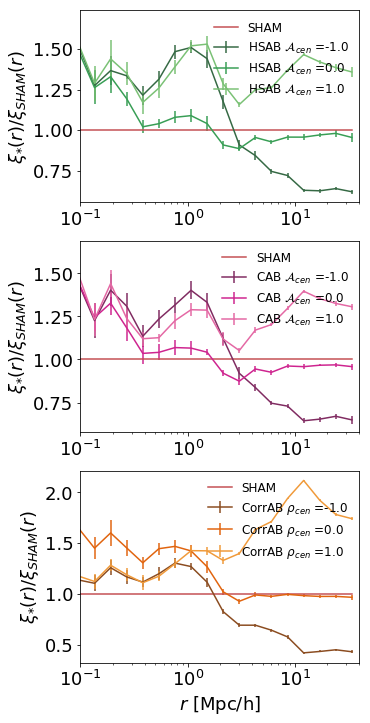

In [39]:
fig, axes = plt.subplots(3,1, figsize = (5,12) )
for ax, model, arr in zip(axes, ['HSAB', 'CAB', 'CorrAB'],\
                          [hsab_xis, ab_xis, corrab_xis]):
    cmap = sns.color_palette(model_color_map[model][1], N)
    if model == 'CorrAB':
        pname = '\\rho'
    else:
        pname = '\\mathcal{A}'
    ax.plot(rbc, sham_xi_2h/sham_xi_2h, label = 'SHAM', color = model_color_map['SHAM'][0])
    #plt.plot(rbc, hod_xi[-n_bins:]/sham_xi_2h, label = 'HOD', color = model_color_map['HOD'][0])
    for i, (abv,c) in enumerate(zip(ab_vals,cmap)):
        ax.errorbar(rbc, arr[i,0][:n_bins]/sham_xi,\
                     yerr = arr[i,1][:n_bins]/sham_xi, label = r'%s $ %s_{cen} $ =%0.1f'%(model,pname, abv), color = c)
        #plt.plot(rbc, ab_xis[i][-n_bins:]/sham_xi_2h, label = 'CAB %0.1f'%abv, color = model_color_map['CAB'][0])
        #plt.plot(rbc, corrab_xis[i][-n_bins:]/sham_xi_2h, label ='CorrAB %0.1f'%abv, color = model_color_map['CorrAB'][0])

    ax.legend(loc = 'best',  frameon=False, fontsize=12)
    #ax.set_ylim([0.85, 1.35])
    ax.set_xlim([0.1, 40])
    ax.set_ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
    ax.set_xscale('log')
axes[2].set_xlabel(r"$r$ [Mpc/h]")

plt.show()

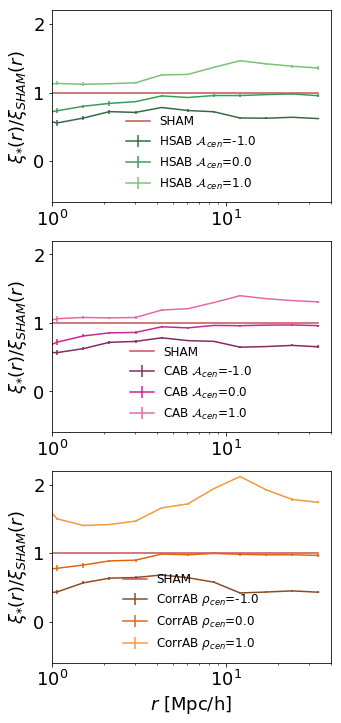

In [41]:
fig, axes = plt.subplots(3,1, figsize = (5,12) )
for ax, model, arr in zip(axes, ['HSAB', 'CAB', 'CorrAB'],\
                          [hsab_xis, ab_xis, corrab_xis]):
    cmap = sns.color_palette(model_color_map[model][1], N)
    if model == 'CorrAB':
        pname = '\\rho'
    else:
        pname = '\\mathcal{A}'
    ax.plot(rbc, sham_xi_2h/sham_xi_2h, label = 'SHAM', color = model_color_map['SHAM'][0])
    #plt.plot(rbc, hod_xi[-n_bins:]/sham_xi_2h, label = 'HOD', color = model_color_map['HOD'][0])
    for i, (abv,c) in enumerate(zip(ab_vals,cmap)):
        ax.errorbar(rbc, arr[i,0][-n_bins:]/sham_xi_2h,\
                     yerr = arr[i,1][-n_bins:]/sham_xi_2h, label = '%s $%s_{cen}$=%0.1f'%(model,pname, abv), color = c)
        #plt.plot(rbc, ab_xis[i][-n_bins:]/sham_xi_2h, label = 'CAB %0.1f'%abv, color = model_color_map['CAB'][0])
        #plt.plot(rbc, corrab_xis[i][-n_bins:]/sham_xi_2h, label ='CorrAB %0.1f'%abv, color = model_color_map['CorrAB'][0])

    ax.legend(loc = 'best',  frameon=False, fontsize=12)
    ax.set_ylim([-0.6, 2.2])
    ax.set_xlim([1, 40])
    ax.set_ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
    ax.set_xscale('log')
axes[2].set_xlabel(r"$r$ [Mpc/h]")

plt.show()

---

In [41]:
def color_to_cmap(color):
    import matplotlib.colors as colors
    from seaborn import utils
    from seaborn.palettes import color_palette, blend_palette
    
    color_rgb = colors.colorConverter.to_rgb(color)
    colors = [utils.set_hls_values(color_rgb, l=l)  # noqa
              for l in np.linspace(1, 0, 12)]
    cmap = blend_palette(colors, as_cmap=True)
    return cmap

In [42]:
def occ_jointplot(catalog, bin_no, mass_bins, params = ('halo_vpeak', sec_haloprop_key ), param_bounds = None ,\
                  color = current_palette[0], ax = None, title = 'Title'):
    
    fig = plt.figure(figsize = (10,10))
    
    mass_cut = np.logical_and(mass_bins[bin_no]< catalog['halo_mvir'], catalog['halo_mvir']<mass_bins[bin_no+1])
    cens_cut= catalog['halo_upid'] == -1
    full_cut = np.logical_and(cens_cut, mass_cut)
    print np.log10(mass_bins[bin_no]), np.log10(mass_bins[bin_no+1]), np.sum(full_cut)
    kit = catalog[full_cut]
    
    xlim = param_bounds[0]
    ylim = param_bounds[1]
    grid = sns.JointGrid(np.log10(kit[params[0]]), np.log10(kit[params[1]]))#, xlim=xlim, ylim=ylim)
    
    cmap = color_to_cmap(color)
    
    grid.plot_joint(sns.kdeplot, cmap = cmap, shade = False, ax = ax, n_levels = 5)#, alpha = 0.4 )
    #grid.plot_joint(plt.hexbin, cmap = cmap, shade = False, ax = ax)#, alpha = 0.4 )

    ax.set_title(title)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #ax.set_xlabel(params[0])
    #ax.set_ylabel(params[1])

    #print np.log10(mass_bins[bin_no])
    #if param_bounds is None:
    #    sns.jointplot(np.log10(kit[params[0]]), np.log10(kit[params[1]]), kind="hex", color = color)
    #else:

    #    sns.jointplot(np.log10(kit[params[0]]), np.log10(kit[params[1]]), xlim=xlim, ylim=ylim, kind="kde",
    #                  color = color, ax = ax, zorder = 0)

    #plt.show()

In [43]:
param_bounds = ((2.4,2.6), (-0.5, 1.5) )

In [44]:
#bin_no = 12
bin_no = 16

In [45]:
from halotools.mock_observables import get_haloprop_of_galaxies

In [46]:
def tabulated_hod_jointplot(sham_hod, hod_model,cmap_name, ab_dict = {},bin_no = 9, ax = None , title = 'Title'):
    sham_cen_hod, sham_sat_hod = sham_hod
    cat2.load_model(1.0, HOD=hod_model, hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               'sec_haloprop_key': sec_haloprop_key, #'halo_%s'%(mag_type),
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod})
    
    cat2.model.param_dict.update(ab_dict)
    
    cat2.populate(min_ptcl=100)
    for sec_param in ['halo_vpeak', sec_haloprop_key]: # TODO let user pass this in
        val_gal = get_haloprop_of_galaxies(cat2.model.mock.galaxy_table['halo_id'], cat2.halocat.halo_table['halo_id'],
                                        cat2.halocat.halo_table[sec_param])
        cat2.model.mock.galaxy_table[sec_param] = val_gal
    occ_jointplot(cat2.model.mock.galaxy_table,bin_no,\
                  mass_bins,param_bounds=param_bounds, color=model_color_map[cmap_name][0], ax = ax, title=title)

In [47]:
%config InlineBackend.close_figures=True 

In [48]:
for fnum in plt.get_fignums():
    plt.close(fnum)

---

In [49]:
from pearce.mocks.customHODModels import Tabulated2DCens, Tabulated2DSats
from pearce.mocks.assembias_models.table_utils import compute_prim_haloprop_bins

In [50]:
from collections import Counter
def compute_occupations(halo_catalog, galaxy_catalog):

    cens_occ = np.zeros((np.sum(halo_catalog['halo_upid'] == -1),))
    sats_occ = np.zeros_like(cens_occ)
    
    detected_central_ids = set(galaxy_catalog[galaxy_catalog['halo_upid']==-1]['halo_id'])
    detected_satellite_upids = Counter(galaxy_catalog[galaxy_catalog['halo_upid']!=-1]['halo_upid'])

    for idx, row  in enumerate(halo_catalog[halo_catalog['halo_upid'] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [51]:
cens_occ, sats_occ = compute_occupations(cat2.halocat.halo_table, galcat)

In [52]:
def calc_2dhod(mass_bins,conc_bins,sec_haloprop_key, halocat, cens_occ, sats_occ):
    
    host_halos = halocat['halo_upid'] == -1
    
    halo_mass = halocat['halo_mvir']
    halo_sec =halocat[sec_haloprop_key]
    
    host_halo_mass = halo_mass[host_halos]
    host_halo_sec = halo_sec[host_halos]

    #host_mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = host_halo_mass)
    mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = halo_mass)
    host_mass_bin_idxs = mass_bin_idxs[host_halos]
    conditional_sec_percentiles = compute_conditional_percentiles(prim_haloprop  = halo_mass,\
                                                                  sec_haloprop = halo_sec,\
                                                                  prim_haloprop_bin_boundaries = mass_bins)
    
    #host_conditional_sec_percentiles = np.zeros((len(galcat),))
    #host_halocat_idxs = np.in1d(halocat['halo_id'], galcat['halo_hostid'], assume_unique=True)
    #print len(galcat), np.sum(host_halocat_idxs)
    #host_sort_idxs = np.argsort(galcat['halo_hostid'])
    #sort_idxs = np.argsort(halocat[host_halocat_idxs]['halo_id'])
    #host_conditional_sec_percentiles[host_sort_idxs] = conditional_sec_percentiles[host_halocat_idxs][sort_idxs]

    host_conditional_sec_percentiles = conditional_sec_percentiles[host_halos]

    mean_ncen = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    mean_nsat = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    
    mass_bin_nos = range(len(mass_bins)-1)#,1)
    
    mean_nhalos = np.zeros_like(mean_ncen)
    for bin_no in mass_bin_nos:
        bin_center = np.mean(mass_bins[bin_no-1:bin_no+1])
        indices_of_host_mb = np.where(host_mass_bin_idxs == bin_no)[0]
        indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]

        if len(indices_of_mb) == 0 or len(indices_of_host_mb) == 0:
            continue
            
        #print np.sum(~np.isfinite(halo_sec[host_conditional_sec_percentiles<0.9])),
        #print np.sum(~np.isfinite(halo_sec[host_conditional_sec_percentiles>0.9]))

            
        #print len(indices_of_mb), len(indices_of_host_mb)
        (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(host_conditional_sec_percentiles[indices_of_host_mb],\
                                                                      cens_occ[indices_of_host_mb],bins=conc_bins, statistic='sum'), \
                                   binned_statistic(host_conditional_sec_percentiles[indices_of_host_mb],\
                                                                      sats_occ[indices_of_host_mb],bins=conc_bins,statistic='sum')

        binned_halos, _, _ = binned_statistic(conditional_sec_percentiles[indices_of_mb],
                                                 None, bins=conc_bins, statistic='count')
        
        mean_ncen[bin_no-1,:] = binned_cens/binned_halos
        mean_nsat[bin_no-1,:] = binned_sats/binned_halos
        
        # NOTE these don't do anytng cuz there are no halos in these bins!
        if np.any(np.isnan(mean_ncen[bin_no-1,:])):
            mean_ncen[bin_no-1,np.isnan(mean_ncen[bin_no-1,:])] = 0.0#np.sum(binne)
            
        if np.any(np.isnan(mean_nsat[bin_no-1,:])):
            mean_nsat[bin_no-1,np.isnan(mean_nsat[bin_no-1,:] )] = 0.0#sat_hod[bin_no-1]
            
        mean_nhalos[bin_no-1,:] = binned_halos
            
    return mean_ncen, mean_nsat, mean_nhalos

In [53]:
#TODO what is up with the last bin? 
conc_bins = np.linspace(0,1,11)
sham_cen_2dhod, sham_sat_2dhod, bh = calc_2dhod(mass_bins, conc_bins, sec_haloprop_key, cat2.halocat.halo_table,
                                        cens_occ, sats_occ)

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [54]:
occupied_bins = bh!=0

In [55]:
def contract_hod(hod, occupied_bins):
    
    contraction = np.zeros(hod.shape[0])
    
    for i in xrange(hod.shape[0]):
        contraction[i] = np.mean(hod[i][occupied_bins[i]])
        
    return contraction

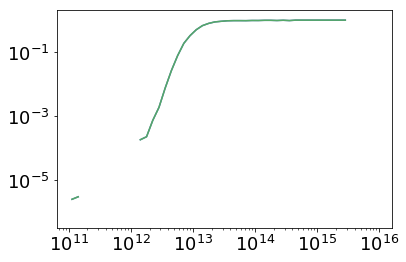

In [56]:
plt.plot(mass_bin_centers, sham_cen_hod)
plt.plot(mass_bin_centers, contract_hod(sham_cen_2dhod, occupied_bins))
#plt.plot(mass_bin_centers, np.nanmean(sham_cen_hod_v2, axis =1))

plt.loglog();

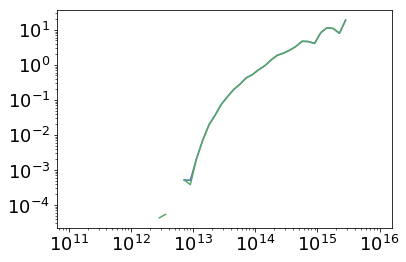

In [57]:
plt.plot(mass_bin_centers, sham_sat_hod)
plt.plot(mass_bin_centers, contract_hod(sham_sat_2dhod, occupied_bins))
plt.loglog();

In [58]:
cat2.model.mock.galaxy_table.colnames

['halo_upid',
 'halo_num_centrals',
 'halo_hostid',
 'halo_local_density_10',
 'halo_y',
 'halo_x',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_num_satellites',
 'conc_NFWmodel',
 'halo_rvir',
 'halo_z',
 'halo_mvir',
 'gal_type',
 'vx',
 'host_centric_distance',
 'vy',
 'y',
 'x',
 'vz',
 'z']

In [59]:
def tabulated_2dhod_xi(sham_2dhod, sec_haloprop_info=(conc_bins, sec_haloprop_key), ab_dict = {}):
    sham_cen_2dhod, sham_sat_2dhod = sham_2dhod
    sec_haloprop_perc_bins, sec_haloprop_key = sec_haloprop_info
    
    
    cat2.load_model(1.0, HOD=(Tabulated2DCens, Tabulated2DSats), hod_kwargs = {'prim_haloprop_bins': mass_bins,
                                                               'sec_haloprop_perc_bins': sec_haloprop_perc_bins,
                                                                'sec_haloprop_key': sec_haloprop_key,
                                                               'cen_hod_vals':sham_cen_2dhod,
                                                               'sat_hod_vals':sham_sat_2dhod})
    
    cat2.model.param_dict.update(ab_dict)
    out = np.zeros((100, 3*(rbins.shape[0]-1),)) 
    for i in xrange(100):
        cat2.populate(min_ptcl=100)
        out[i, :len(rbins)-1] = cat2.calc_xi(rbins)

        gal_pos = np.vstack(np.array(cat2.model.mock.galaxy_table[coord]) for coord in ['x', 'y', 'z']).T/cat2.h           
        xi_1h, xi_2h = tpcf_one_two_halo_decomp(gal_pos, cat2.model.mock.galaxy_table['halo_hostid'], rbins, do_cross = False,\
                                                  estimator = 'Landy-Szalay', num_threads = 4, period = cat2.Lbox/cat2.h)
                   
        out[i, len(rbins)-1:] = np.r_[xi_1h.squeeze(), xi_2h.squeeze()]
        
    return out.mean(axis = 0), out.std(axis=0)/out.mean(axis=0)

In [60]:
xi_2d, xi_err_2d = tabulated_2dhod_xi((sham_cen_2dhod, sham_sat_2dhod))

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[]

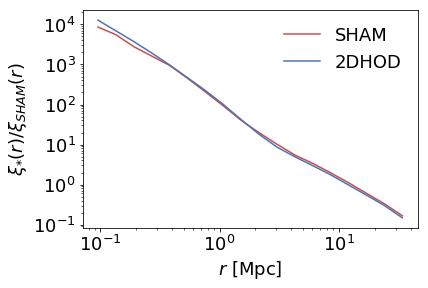

In [61]:
plt.plot(rbc, sham_xi, label = 'SHAM', color = model_color_map['SHAM'][0])
plt.plot(rbc, xi_2d[:len(rbc)], label = '2DHOD', color = model_color_map['HOD'][0])

#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best', frameon=False)
#plt.ylim([0.9, 1.05])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.loglog()

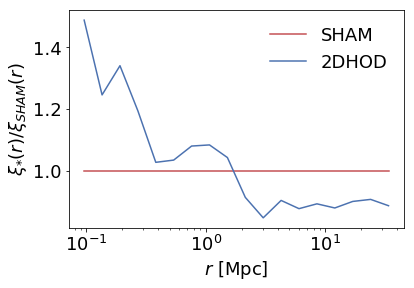

In [62]:
plt.plot(rbc, sham_xi/sham_xi, label = 'SHAM', color = model_color_map['SHAM'][0])
plt.plot(rbc, xi_2d[:len(rbc)]/sham_xi, label = '2DHOD', color = model_color_map['HOD'][0])

#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best', frameon=False)
#plt.ylim([0.9, 1.05])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.xscale('log')

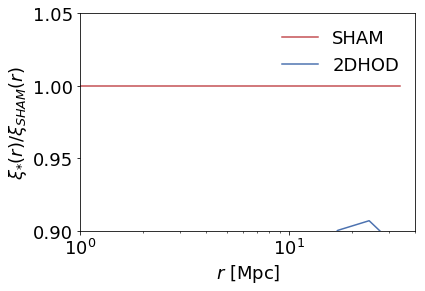

In [63]:
plt.plot(rbc, sham_xi_2h/sham_xi_2h, label = 'SHAM', color = model_color_map['SHAM'][0])
plt.plot(rbc, xi_2d[-len(rbc):]/sham_xi_2h, label = '2DHOD', color = model_color_map['HOD'][0])

#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best', frameon=False)
plt.ylim([0.9, 1.05])
plt.xlim([1.0, 40.0])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.xscale('log')

In [ ]:
vpeak_bins = np.linspace(0,1,11)

In [ ]:
xi_2d_vpeak, xi_err_2d_vpeak = tabulated_2dhod_xi((sham_cen_2dhod, sham_sat_2dhod), (vpeak_bins, 'halo_vpeak'))

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [ ]:
xi_2d_conc, xi_err_2d_conc= tabulated_2dhod_xi((sham_cen_2dhod, sham_sat_2dhod), (vpeak_bins, 'halo_nfw_conc'))

In [ ]:
plt.plot(rbc, sham_xi/sham_xi, label = 'SHAM', color = model_color_map['SHAM'][0])


plt.errorbar(rbc, xi_2d[:len(rbc)]/sham_xi, yerr = xi_err_2d_vpeak[-len(rbc):], label = r'$2DHOD; \rho_{h}$', color = model_color_map['HOD'][0])
plt.errorbar(rbc, xi_2d_vpeak[:len(rbc)]/sham_xi, yerr = xi_err_2d_vpeak[-len(rbc):], label = r'$2DHOD\; V_{peak}$', color = model_color_map['CorrAB'][0])
plt.errorbar(rbc, xi_2d_conc[:len(rbc)]/sham_xi, yerr = xi_err_2d_vpeak[-len(rbc):], label = r'$2DHOD\; c_{nfw}$', color = model_color_map['CorrAB'][0])


#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best', frameon=False)
#plt.ylim([0.9, 1.05])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.xscale('log')

In [ ]:
plt.show();

In [ ]:
plt.plot(rbc, sham_xi_2h/sham_xi_2h, label = 'SHAM', color = model_color_map['SHAM'][0])
plt.errorbar(rbc, xi_2d[-len(rbc):]/sham_xi_2h, yerr = xi_err_2d_vpeak[-len(rbc):], label = r'$2DHOD\; \rho_h$', color = model_color_map['HOD'][0])
plt.errorbar(rbc, xi_2d_vpeak[-len(rbc):]/sham_xi_2h, yerr = xi_err_2d_vpeak[-len(rbc):], label = r'$2DHOD\; V_{peak}$', color = model_color_map['CorrAB'][0])
plt.errorbar(rbc, xi_2d_conc[-len(rbc):]/sham_xi_2h, yerr = xi_err_2d_vpeak[-len(rbc):], label = r'$2DHOD\; c_{nfw}$', color = model_color_map['CAB'][0])

#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best', frameon=False, fontsize = 12)
plt.ylim([0.85, 1.15])
plt.xlim([1.0, 40.0])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.xscale('log')

---

In [ ]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**12.0 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['SHAM'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(sham_cen_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(x)|M>$')
plt.yscale('log')
plt.ylim([0.1, 1.1])
plt.legend(loc='best', frameon=False)

In [ ]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**12.0 < mass_bin_centers, mass_bin_centers < 10**14.5)
colors = sns.color_palette(model_color_map['SHAM'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(sham_sat_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{sat}(x)|M>$')
plt.yscale('log')
#plt.ylim([0.1, 1.1])
plt.legend(loc='best', frameon=False)

In [ ]:
cat2.load_model(1.0, HOD='corrZheng07', hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               'sec_haloprop_key': 'halo_vpeak',#%(mag_type),
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod} )
ab_dict = {'mean_occupation_centrals_assembias_corr1':1.0,
                                       'mean_occupation_satellites_assembias_corr1':-1.0}
cat2.model.param_dict.update(ab_dict)
cat2.populate(min_ptcl=100)


In [ ]:
cens_occ_hod, sats_occ_hod = compute_occupations(cat2.halocat.halo_table, cat2.model.mock.galaxy_table)

In [ ]:
hod_cen_2dhod, hod_sat_2dhod = calc_2dhod(mass_bins, conc_bins, 'halo_vpeak', cat2.halocat.halo_table,
                                        cens_occ_hod, sats_occ_hod)

In [ ]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**11.5 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['CorrAB'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(hod_cen_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
plt.ylim(0.1,1.1)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(c)|M>$')
plt.yscale('log')
plt.legend(loc='best', frameon=False)

In [ ]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**11.5 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['CorrAB'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(hod_sat_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
#plt.ylim(0.1,1.1)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(c)|M>$')
plt.yscale('log')
plt.legend(loc='best', frameon=False)

In [ ]:
cat2.load_model(1.0, HOD='hsabZheng07', hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               'sec_haloprop_key': 'halo_vpeak',
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod} )
ab_dict = {'mean_occupation_centrals_assembias_param1':1.0,
                                       'mean_occupation_satellites_assembias_param1':-1.0}
cat2.model.param_dict.update(ab_dict)
cat2.populate(min_ptcl=100)


In [ ]:
cens_occ_hod, sats_occ_hod = compute_occupations(cat2.halocat.halo_table, cat2.model.mock.galaxy_table)

In [ ]:
hod_cen_2dhod, hod_sat_2dhod = calc_2dhod(mass_bins, conc_bins, 'halo_vpeak', cat2.halocat.halo_table,
                                        cens_occ_hod, sats_occ_hod)

In [ ]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**11.5 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['HSAB'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(hod_cen_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
plt.ylim(0.1,1.1)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(c)|M>$')
#plt.yscale('log')
plt.legend(loc='best', frameon=False)